In [1]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\04_multitask'

In [2]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\04_multitask'

In [3]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\04_multitask'

In [4]:
# --- Pretrained YOLOv5 object detection on a folder of images ---
# Works with torch.hub (Ultralytics YOLOv5). No training required.

#1. Import Necessary Liobraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
import shutil
from tqdm.auto import tqdm as notebook_tqdm
import tqdm
import tensorflow as tf

import pandas as pd
import numpy as np
from PIL import Image

import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Input, AveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1

from keras.optimizers import Adam
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#import torchvision.transforms as transforms

#import warnings
#warnings.filterwarnings("ignore")


### Loading the dataset

In [5]:
IMAGE_FOLDER = r"Z:\EE_297A\dataset\lanes\images"
MASK_FOLDER = r"Z:\EE_297A\dataset\lanes\masks"

In [6]:
def create_dirs_if_not_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Directory created:", path)
    else:
        print("Directory already exists:", path)

In [7]:
create_dirs_if_not_exist(IMAGE_FOLDER)
create_dirs_if_not_exist(MASK_FOLDER)

Directory already exists: Z:\EE_297A\dataset\lanes\images
Directory already exists: Z:\EE_297A\dataset\lanes\masks


In [8]:
### Copy Images to  the Directory:
"""
This code is a data pre-processing script that goes through the TuSimple dataset’s
train_set/clips directory and copies only the 20th frame of each video clip into a single
flat folder — typically to simplify training or dataset access.
"""

CLIPS_PATH = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\clips"

# iterate through each directory
for clip_dir in os.listdir(CLIPS_PATH):
    clip_dir_path = os.path.join(CLIPS_PATH, clip_dir)

    print("Processing Clip:", clip_dir)
    # iterate through each sub directory
    for frame_dir in os.listdir(clip_dir_path):
        frame_path = os.path.join(clip_dir_path, frame_dir, "20.jpg")

        # check if file is present
        if not os.path.isfile(frame_path):
            continue

        # create new filename based on last 2 directory names
        clip_name = os.path.basename(os.path.dirname(frame_path))
        date_name = os.path.basename(os.path.dirname(os.path.dirname(frame_path)))
        new_filename = f"{date_name}_{clip_name}.jpg"
        new_file_path = os.path.join(IMAGE_FOLDER, new_filename)

        # copy the file
        shutil.copy(frame_path, new_file_path)


Processing Clip: 0313-1
Processing Clip: 0313-2
Processing Clip: 0531
Processing Clip: 0601


In [9]:
print("Total images in dataset:", len(os.listdir(IMAGE_FOLDER)))

Total images in dataset: 3626


In [83]:
# load the dataset json files
"""
Code Purpose: Load and combine TuSimple lane label JSONs
lines=True tells pandas each line is a separate JSON object (which is true for TuSimple).
Each line describes a labeled frame's lanes + metadata.
"""
### Train:
df1_313 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0313.json", lines = True)
df2_531 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0531.json", lines = True)
df3_601 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0601.json", lines = True)

# combine into single dataframe
df_json = pd.concat([df1_313, df2_531, df3_601])
df_json.head()

#Test
df_json_test = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\test_set\test_tasks_0627.json", lines = True)



### Creating the Masks
1. What is a mask?
Mask: Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.
2. Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.

In [11]:
# create function for generating masks
def generate_lane_mask(row):
    # create a mask of all zeros
    mask = np.zeros((728, 1280, 1), dtype=np.uint8)

    # extract data from the row
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane = 1, non-lane = 0
    for lane in lanes:
        # exclude -2 datapoints
        h_samples_filtered = [y for x, y in zip(lane, h_samples) if x != -2]
        lane_filtered = [x for x in lane if x != -2]

        # create array of lane points
        lane_points = np.array(list(zip(lane_filtered, h_samples_filtered)))

        # update lane mask
        cv2.polylines(mask, [lane_points], isClosed = False, color = (255, 255, 255), thickness = 15)
    
    # generate mask filename
    raw_file_path = os.path.normpath(raw_file)  # handles / vs \ properly
    clip_name = os.path.basename(os.path.dirname(raw_file_path))     # e.g., 5160
    date_name = os.path.basename(os.path.dirname(os.path.dirname(raw_file_path)))  # e.g., 0313-1
    mask_filename = f"{date_name}_{clip_name}.jpg"
    mask_filename_path = os.path.join(MASK_FOLDER, mask_filename)

    # write the mask image
    cv2.imwrite(mask_filename_path, mask)

In [12]:
# generate masks
from tqdm import tqdm  # ✅ Ensure this import is present

for index, row in tqdm(df_json.iterrows(), total=len(df_json)):
    generate_lane_mask(row)

100%|█████████████████████████████████████████████████████████████████████████████| 3626/3626 [00:10<00:00, 343.69it/s]


In [13]:
def visualize_image(image_name):
    # get paths
    image_path = os.path.join(IMAGE_FOLDER, image_name)
    mask_path = os.path.join(MASK_FOLDER, image_name)
    
    # read the image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    
    # plot the image
    plt.figure(figsize = (20, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Road Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    
    # show the images
    plt.show()

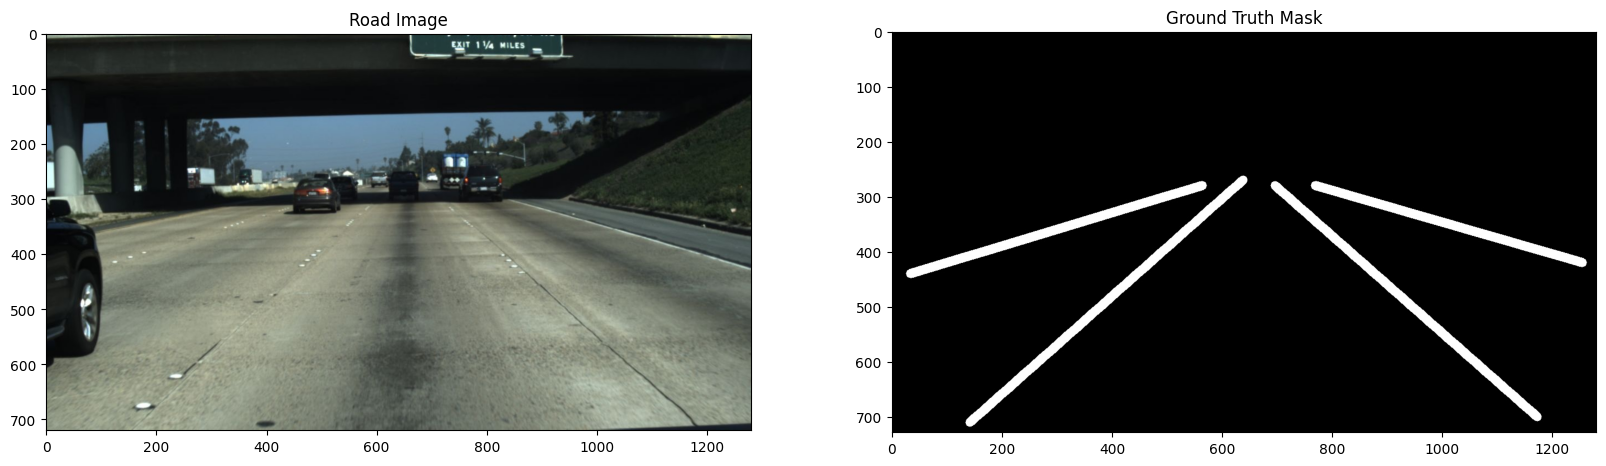

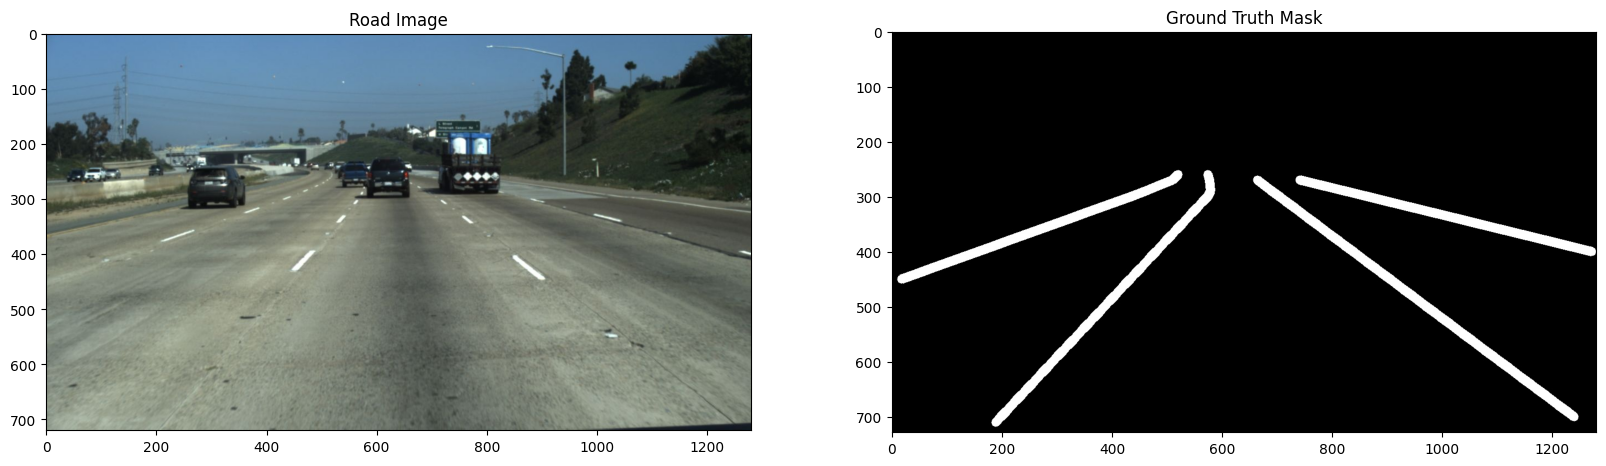

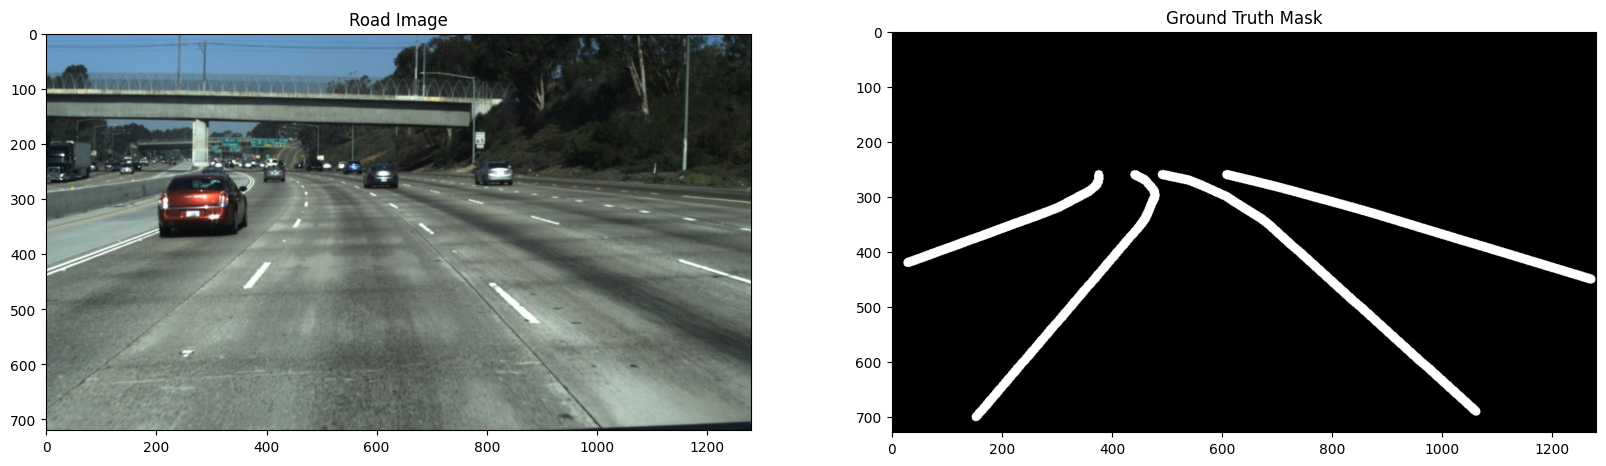

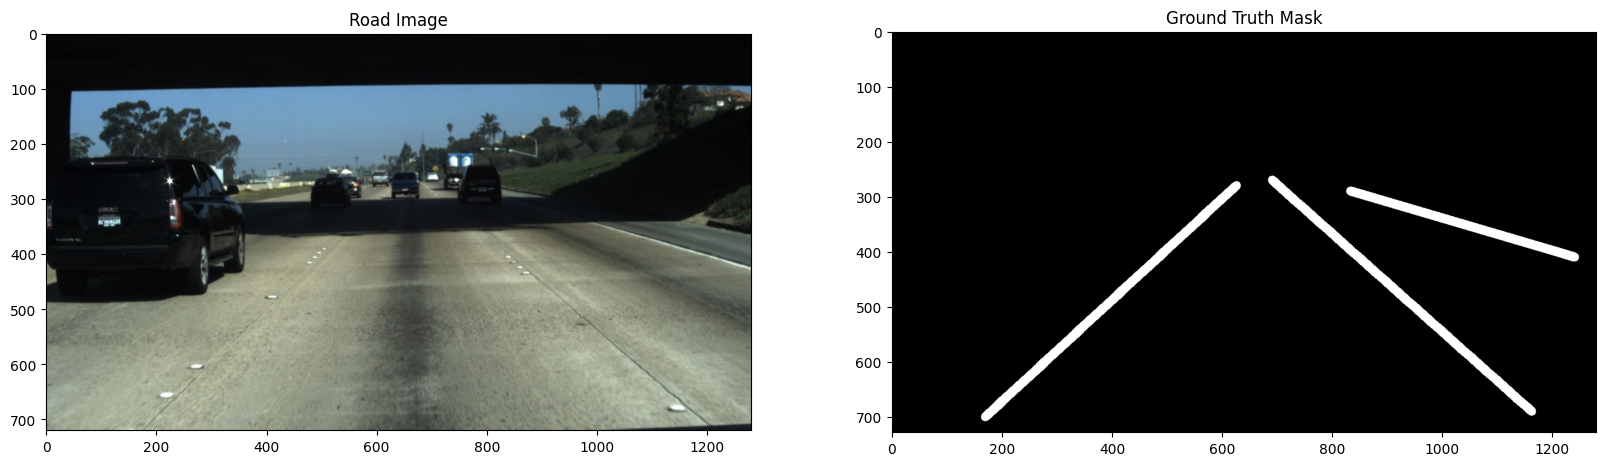

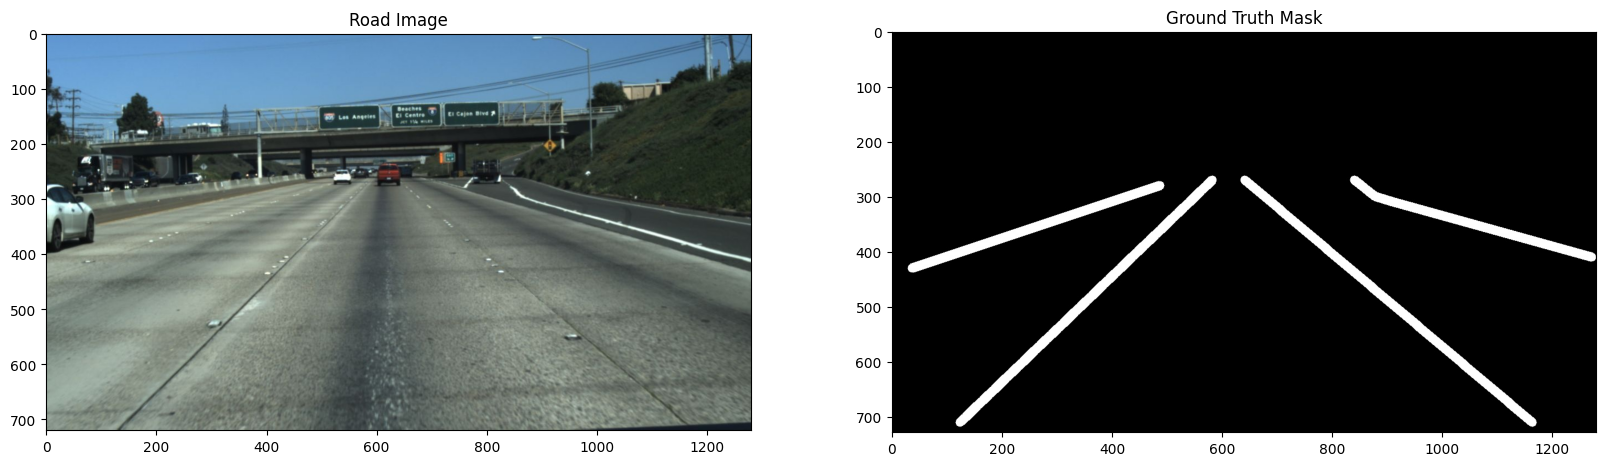

In [14]:
for i in range(5):
    image_name = random.choice(os.listdir(IMAGE_FOLDER))
    visualize_image(image_name)

### Training and Testing Splits and Processing
    1. Images
    2. Masks 

In [15]:
lane_train_image_folder = r"Z:\EE_297A\dataset\lanes\train\images"
lane_test_image_folder = r"Z:\EE_297A\dataset\lanes\test\images"
lane_train_mask_folder = r"Z:\EE_297A\dataset\lanes\train\masks"
lane_test_mask_folder = r"Z:\EE_297A\dataset\lanes\test\masks"

In [16]:
for folder_path in [lane_train_image_folder, lane_test_image_folder, lane_train_mask_folder, lane_test_mask_folder]:
    create_dirs_if_not_exist(folder_path)

Directory already exists: Z:\EE_297A\dataset\lanes\train\images
Directory already exists: Z:\EE_297A\dataset\lanes\test\images
Directory already exists: Z:\EE_297A\dataset\lanes\train\masks
Directory already exists: Z:\EE_297A\dataset\lanes\test\masks


In [17]:
from sklearn.model_selection import train_test_split
images = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith(".jpg")]
masks = [file for file in os.listdir(MASK_FOLDER) if file.endswith(".jpg")]

# split for train and test
lane_train_images, lane_val_images = train_test_split(images, test_size=0.1, random_state=42)

### Feature Engineering
    What is feature engineering:
    Feature engineering is the process of creating, transforming, or selecting input variables (features) from raw data in order to improve the performance of a machine learning model.

    1. Image Loading and Preprocessing
    2. Image Sharpening Using a Convolution Kernel
    3. Mask Loading and Normalization
    4.

In [18]:
import tensorflow as tf

def load_image(image_path, mask_path):
    size = [224, 224]

    # 1. Image Loading and Preprocessing
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = image / 255.0  

    # 2. Image Sharpening Using a Convolution Kernel
    kernel = tf.constant([[0., -1., 0.],
                          [-1., 5., -1.],
                          [0., -1., 0.]], dtype=tf.float32)
    kernel = tf.reshape(kernel, [3, 3, 1, 1])

    channels = tf.split(image, num_or_size_splits=3, axis=-1)
    sharpened_channels = []
    for c in channels:
        c_sharp = tf.nn.conv2d(tf.expand_dims(c, axis=0), kernel, strides=1, padding="SAME")
        sharpened_channels.append(tf.squeeze(c_sharp, axis=0))
    image = tf.concat(sharpened_channels, axis=-1)
    image = tf.clip_by_value(image, 0.0, 1.0)  

   # 3. Mask Loading and Normalization
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, size)
    mask = mask / 255.0  
    
    return image, mask

In [19]:
def dataset_from_folder(image_folder, mask_folder):
    image_files = sorted([os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(".jpg")])
    mask_files = sorted([os.path.join(mask_folder, file) for file in os.listdir(mask_folder) if file.endswith(".jpg")])

    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda image_path, mask_path: load_image(image_path, mask_path))
    
    return dataset


In [20]:
# load dataset from folder
lane_train_dataset = dataset_from_folder(lane_train_image_folder, lane_train_mask_folder)
lane_test_dataset = dataset_from_folder(lane_test_image_folder, lane_test_mask_folder)

### YOLOv5 Pretrained Model OBJECT DETECTION ONLY AUTOSHAPE

In [21]:
from pathlib import Path
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

VEHICLE_SET = {'car','bus','truck','motorcycle','bicycle'}
_YOLO = None

def _load_yolo(variant="yolov5s", conf=0.25, iou=0.45):
    global _YOLO
    if _YOLO is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        m = torch.hub.load("ultralytics/yolov5", variant, pretrained=True)
        m = m.to(device).eval()
        m.conf = conf
        m.iou = iou
        m.max_det = 300
        m.agnostic = False
        _YOLO = m
        print(f"[YOLO] {variant} loaded on {device}")
    return _YOLO

def show_yolo_on_df_index(
    df,
    idx: int,
    dataset_root: str,
    vehicles_only: bool = True,
    img_size: int = 640,
    yolo_variant: str = "yolov5s",
    conf_thres: float = 0.25,
    iou_thres: float = 0.45,
    save: bool = False,
    out_dir: str = "./yolo_vis"
):
    """
    Run YOLOv5 on an image referenced inside a DataFrame row.
    DataFrame must have a 'raw_file' column with relative paths (like 'clips/.../xxx.jpg').
    """
    # Build full path
    img_rel = str(df.iloc[idx]["raw_file"])
    img_path = str(Path(dataset_root) / img_rel)
    if not Path(img_path).is_file():
        raise FileNotFoundError(f"Image not found: {img_path}")

    # Load YOLO
    model = _load_yolo(yolo_variant, conf_thres, iou_thres)

    # Run inference
    with torch.inference_mode():
        results = model([img_path], size=img_size)

    # Open image for drawing
    im = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(im)
    font = ImageFont.load_default()

    # Extract predictions
    preds = results.xyxy[0].cpu().tolist()  # [x1,y1,x2,y2,conf,cls]
    drawn = 0
    for x1, y1, x2, y2, conf, cls_id in preds:
        name = model.names[int(cls_id)]
        if vehicles_only and name not in VEHICLE_SET:
            continue
        drawn += 1
        draw.rectangle([(x1,y1),(x2,y2)], outline=(0,255,0), width=3)
        label = f"{name} {conf:.2f}"
        draw.text((x1, y1-10), label, fill=(0,255,0), font=font)

    if drawn == 0:
        msg = "No vehicles detected" if vehicles_only else "No objects detected"
        draw.text((10,10), msg, fill=(255,0,0), font=font)

    # Show inline
    plt.figure(figsize=(12,7))
    plt.imshow(im)
    plt.axis("off")
    plt.show()

    # Optionally save
    if save:
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        out_path = Path(out_dir) / f"{Path(img_path).stem}_yolo.png"
        im.save(out_path)
        print(f"Saved: {out_path}")


In [22]:
%matplotlib inline
DATASET_ROOT = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set"  # folder that contains 'clips'

show_yolo_on_df_index(
    df=df_json,
    idx=300,                 # pick a row from your DataFrame
    dataset_root=DATASET_ROOT,
    vehicles_only=True,    # True = only cars/bus/truck/motorcycle/bicycle
    save=False
)

WARNING torchvision==0.20 is incompatible with torch==2.4.
Run 'pip install torchvision==0.19' to fix torchvision or 'pip install -U torch torchvision' to update both.
For a full compatibility table see https://github.com/pytorch/vision#installation


Using cache found in C:\Users\Baron/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-8-13 Python-3.8.20 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
C:\Users\Baron/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


[YOLO] yolov5s loaded on cuda


### YOLOv5 Pretrained Model OBJECT DETECTION ONLY 

In [23]:
import sys
sys.path.append(r"C:\Users\Baron\Desktop\yolov5")  # folder that contains utils/, models/, etc.

from utils.general import non_max_suppression, scale_boxes

In [24]:
from utils.general import non_max_suppression, scale_boxes
from models.common import DetectMultiBackend

In [25]:
import cv2
import numpy as np

def letterbox(im, new_shape=640, color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    """
    Resize and pad image while meeting stride-multiple constraints.
    Returns: image, (ratio_w, ratio_h), (pad_w, pad_h)
    """
    shape = im.shape[:2]  # current shape [height, width]

    # Scale ratio (new / old)
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])  # scale ratio
    if not scaleup:  # only scale down
        r = min(r, 1.0)

    # Compute padding
    new_unpad = (int(round(shape[1] * r)), int(round(shape[0] * r)))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # width/height padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # make divisible by stride
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        r = new_shape[1] / shape[1], new_shape[0] / shape[0]

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)

    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return im, (r, r), (dw, dh)

In [26]:
cd C:\Users\Baron\Desktop\EE_297_Repo\EE_297\ML_PATH_EE297\EE297_env\01_main\04_multitask

C:\Users\Baron\Desktop\EE_297_Repo\EE_297\ML_PATH_EE297\EE297_env\01_main\04_multitask


In [27]:
import cv2, numpy as np, torch, torch.nn as nn
from utils.general import non_max_suppression, scale_boxes

VEHICLE_SET = {'car','bus','truck','motorcycle','bicycle'}

def letterbox(im, new_shape=640, color=(114,114,114), auto=True, scaleFill=False, scaleup=True, stride=32):
    shape = im.shape[:2]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)
    r = min(new_shape[0]/shape[0], new_shape[1]/shape[1])
    if not scaleup:
        r = min(r, 1.0)
    new_unpad = (int(round(shape[1]*r)), int(round(shape[0]*r)))
    dw, dh = new_shape[1]-new_unpad[0], new_shape[0]-new_unpad[1]
    if auto:
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)
    elif scaleFill:
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        r = (new_shape[1]/shape[1], new_shape[0]/shape[0])
    dw /= 2; dh /= 2
    if shape[::-1] != new_unpad:
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh-0.1)), int(round(dh+0.1))
    left, right = int(round(dw-0.1)), int(round(dw+0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return im, (r, r), (dw, dh)

class YoloV5VehicleDetectorRaw(nn.Module):
    def __init__(self, variant="yolov5s", pretrained=True,
                 conf=0.25, iou=0.45, max_det=300, agnostic=False):
        super().__init__()
        yolo = torch.hub.load("ultralytics/yolov5", variant, pretrained=pretrained)
        if hasattr(yolo, "model"):
            yolo = yolo.model
        self.yolo = yolo.eval()
        self.yolo.conf = conf; self.yolo.iou = iou
        self.yolo.max_det = max_det; self.yolo.agnostic = agnostic
        self.names = getattr(self.yolo, "names", None)
        self.vehicle_ids = {i for i, n in enumerate(self.names or []) if n in VEHICLE_SET}
        self.stride = int(getattr(self.yolo, "stride", 32))

    @torch.inference_mode()
    def forward(self, img_path_or_np, size=640, device=None):
        dev = device or ("cuda" if torch.cuda.is_available() else "cpu")
    
        # 1) Load image (RGB np.array HxWx3)
        if isinstance(img_path_or_np, str):
            im0 = cv2.imread(img_path_or_np)
            if im0 is None:
                raise FileNotFoundError(img_path_or_np)
            im0 = im0[:, :, ::-1]  # BGR->RGB
        else:
            im0 = img_path_or_np
        H0, W0 = im0.shape[:2]
    
        # 2) Letterbox + to tensor BCHW in [0,1]
        lb, _, _ = letterbox(im0, new_shape=size, stride=self.stride)
        im = torch.from_numpy(np.ascontiguousarray(lb.transpose(2, 0, 1))).float() / 255.0
        im = im.unsqueeze(0).to(dev)  # ensure B=1
    
        # 3) Raw forward
        pred_raw = self.yolo(im)          # could be tensor OR list/tuple/dict
        # ---- normalize to [B, N, 5+nc(+nm)] tensor ----
        if isinstance(pred_raw, (list, tuple)):
            pred = pred_raw[0]
        elif isinstance(pred_raw, dict) and "pred" in pred_raw:
            pred = pred_raw["pred"]
        else:
            pred = pred_raw
    
        if pred.ndim == 2:                # [N, 85] -> [1, N, 85]
            pred = pred.unsqueeze(0)
        elif pred.ndim != 3:
            raise RuntimeError(f"Unexpected YOLO output shape: {pred.shape}")
    
        # 4) NMS
        nms_out = non_max_suppression(
            pred,
            conf_thres=self.yolo.conf,
            iou_thres=self.yolo.iou,
            classes=None,
            agnostic=self.yolo.agnostic,
            max_det=self.yolo.max_det
        )
        det = nms_out[0]
        if det is None or len(det) == 0:
            return torch.empty((0, 6), device=im.device)
    
        # 5) Scale boxes back to original image size
        det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()
    
        # 6) Filter to vehicle classes (optional)
        if self.vehicle_ids:
            mask = torch.tensor([int(c.item()) in self.vehicle_ids for c in det[:, 5]],
                                dtype=torch.bool, device=det.device)
            det = det[mask]
        return det


In [28]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

def draw_boxes(im, dets, names, title):
    im = im.copy(); d = ImageDraw.Draw(im); f = ImageFont.load_default()
    for x1,y1,x2,y2,conf,cls_id in dets:
        cls = int(cls_id); name = names[cls] if names and cls < len(names) else str(cls)
        d.rectangle([(x1,y1),(x2,y2)], outline=(0,255,0), width=3)
        d.text((x1, max(0,y1-10)), f"{name} {float(conf):.2f}", fill=(0,255,0), font=f)
    plt.imshow(im); plt.title(title); plt.axis("off")

@torch.inference_mode()
def parity_test(img_path, variant="yolov5s", conf=0.25, iou=0.45, size=640):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    base = torch.hub.load("ultralytics/yolov5", variant, pretrained=True).to(device).eval()
    base.conf, base.iou, base.max_det, base.agnostic = conf, iou, 300, False
    det_base = base(img_path, size=size).xyxy[0].cpu().numpy()

    raw = YoloV5VehicleDetectorRaw(variant=variant, pretrained=True, conf=conf, iou=iou).to(device).eval()
    det_raw = raw(img_path, size=size).cpu().numpy()

    print("AutoShape:", det_base.shape, "\n", det_base[:5])
    print("Raw+letterbox:", det_raw.shape, "\n", det_raw[:5])

    im0 = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1); draw_boxes(im0, det_base, base.names, "AutoShape")
    plt.subplot(1,2,2); draw_boxes(im0, det_raw, raw.names, "Raw + letterbox (ours)")
    plt.show()

parity_test("img_1.jpg")


Using cache found in C:\Users\Baron/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-8-13 Python-3.8.20 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
C:\Users\Baron/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Using cache found in C:\Users\Baron/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-8-13 Python-3.8.20 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


AutoShape: (9, 6) 
 [[     321.57      259.65      550.44      423.41     0.91504           2]
 [     614.22      232.37      708.53      308.41     0.89653           2]
 [     744.49      222.61       782.8      257.44     0.77113           2]
 [     400.83      224.86      443.11      251.28     0.66393           2]
 [     448.04      228.73      484.24       248.5     0.60384           2]]
Raw+letterbox: (9, 6) 
 [[        322         260         550         423     0.91482           2]
 [        614         232         709         308     0.89696           2]
 [        744         223         783         257     0.76866           2]
 [        401         225         443         251     0.66156           2]
 [        448         229         484         249     0.60627           2]]


In [29]:
from pathlib import Path
%matplotlib inline
def show_vehicle_on_df_index(df, idx, dataset_root, detector, size=640, save=False, out_dir="./yolo_vis"):
    """
    Run detection with your raw YOLO wrapper (no AutoShape) on an image
    from your dataframe and draw boxes.
    """
    img_rel = str(df.iloc[idx]["raw_file"])
    img_path = str(Path(dataset_root) / img_rel)

    # run your raw detector (already does letterbox + NMS)
    dets = detector(img_path, size=size).cpu().numpy()

    # draw results
    im = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(im)
    font = ImageFont.load_default()
    for x1, y1, x2, y2, conf, cls_id in dets:
        name = detector.names[int(cls_id)]
        label = f"{name} {conf:.2f}"
        draw.rectangle([(x1, y1), (x2, y2)], outline=(0,255,0), width=3)
        draw.text((x1, max(0,y1-10)), label, fill=(0,255,0), font=font)

    plt.figure(figsize=(12,7))
    plt.imshow(im)
    plt.axis("off")
    plt.show()

    if save:
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        out_file = Path(out_dir) / f"{Path(img_path).stem}_veh.png"
        im.save(out_file)
        print("Saved:", out_file)


Using cache found in C:\Users\Baron/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-8-13 Python-3.8.20 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


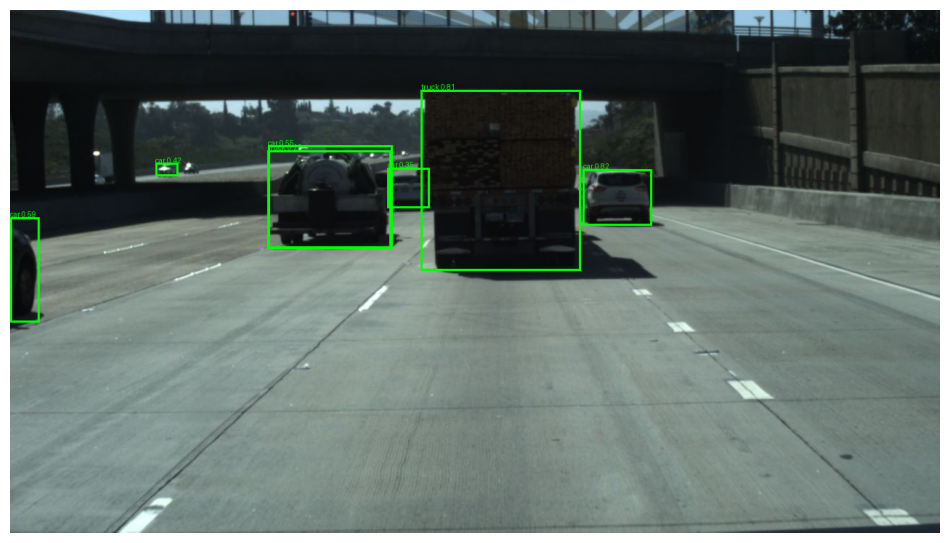

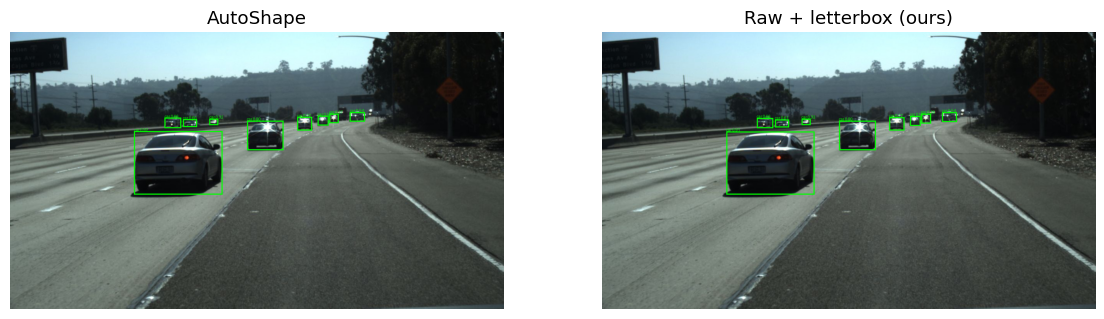

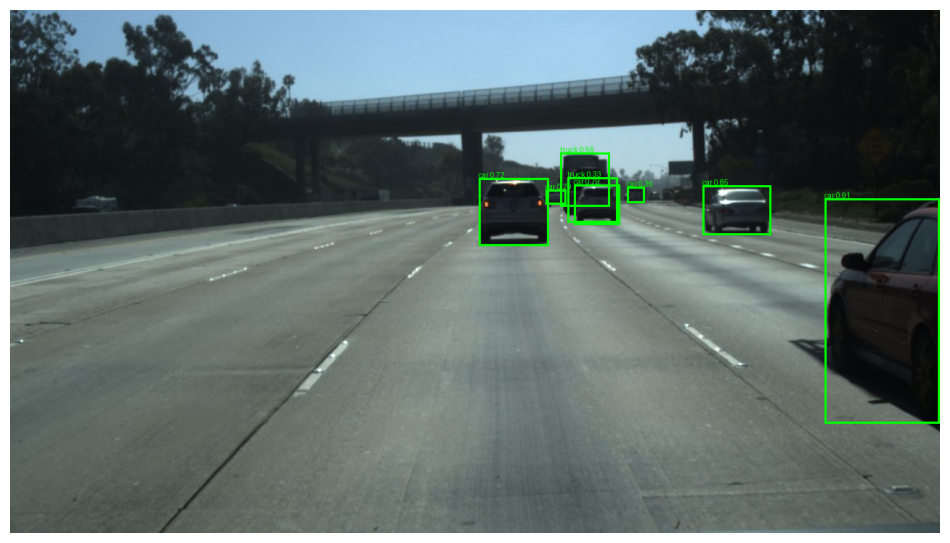

In [30]:
%matplotlib inline
DATASET_ROOT = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set"  # folder that contains 'clips'
detector = YoloV5VehicleDetectorRaw("yolov5s", pretrained=True, conf=0.25, iou=0.45).eval().to("cuda" if torch.cuda.is_available() else "cpu")
show_vehicle_on_df_index(df_json, idx=20, dataset_root=DATASET_ROOT, detector=detector)

### YOLOv5 Pretrained Model WITH SEGMENTATION

In [31]:
### WORKING!!!!
# yolo_with_seg.py
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Optional
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

from utils.general import non_max_suppression, scale_boxes


# ----------------------------
# Segmentation head (simple FPN)
# ----------------------------
class PyramidSegHead(nn.Module):
    """
    Inputs: feats [P3, P4, P5] (largest->smallest), out_hw=(H, W)
    Output: logits B x out_ch x H x W
    """
    def __init__(self, out_ch=1, fuse_ch=128):
        super().__init__()
        self.l3 = nn.LazyConv2d(fuse_ch, 1)  # for P5
        self.l2 = nn.LazyConv2d(fuse_ch, 1)  # for P4
        self.l1 = nn.LazyConv2d(fuse_ch, 1)  # for P3
        self.s4 = nn.Conv2d(fuse_ch, fuse_ch, 3, padding=1)
        self.s3 = nn.Conv2d(fuse_ch, fuse_ch, 3, padding=1)
        self.o1 = nn.Conv2d(fuse_ch, 64, 3, padding=1)
        self.o2 = nn.Conv2d(64, 32, 3, padding=1)
        self.logits = nn.Conv2d(32, out_ch, 1)

    def forward(self, feats: List[torch.Tensor], out_hw: Tuple[int, int]):
        p3, p4, p5 = feats
        t5 = self.l3(p5)
        t4 = self.l2(p4) + F.interpolate(t5, size=p4.shape[-2:], mode="nearest")
        t4 = F.relu(self.s4(t4), inplace=True)
        t3 = self.l1(p3) + F.interpolate(t4, size=p3.shape[-2:], mode="nearest")
        t3 = F.relu(self.s3(t3), inplace=True)
        x = F.relu(self.o1(t3), inplace=True)
        x = F.relu(self.o2(x), inplace=True)
        x = self.logits(x)
        x = F.interpolate(x, size=out_hw, mode="bilinear", align_corners=False)
        return x  # logits


# ----------------------------
# Shared encoder multitask model
# ----------------------------
class YoloV5WithSeg(nn.Module):
    """
    ONE model: YOLO backbone+neck+Detect (shared) + a segmentation head.

    Training:
        forward(images_01: torch.Tensor[B,3,H,W]) -> (pred_raw, seg_logits)
        - seg_logits are *logits*; use BCEWithLogitsLoss or similar.

    Inference:
        detect(path_or_np, size=640) -> (det_xyxy[N,6], seg_prob[H,W])
    """
    def __init__(self, yolo_variant="yolov5s", pretrained=True,
                 seg_out_ch=1, fuse_ch=128,
                 conf=0.25, iou=0.45, max_det=300, agnostic=False):
        super().__init__()
        yolo = torch.hub.load("ultralytics/yolov5", yolo_variant, pretrained=pretrained)
        if hasattr(yolo, "model"):  # unwrap AutoShape
            yolo = yolo.model

        self.yolo = yolo
        self.yolo.conf = conf
        self.yolo.iou = iou
        self.yolo.max_det = max_det
        self.yolo.agnostic = agnostic
        self.stride = int(getattr(self.yolo, "stride", 32))
        self.yolo.eval()

        # store names safely
        raw_names = getattr(self.yolo, "names", None)
        if isinstance(raw_names, dict):
            self.names = [raw_names[i] for i in range(len(raw_names))]
        elif isinstance(raw_names, (list, tuple)):
            self.names = list(raw_names)
        else:
            self.names = []

        # find Detect head
        self.detect_head = None
        for m in self.yolo.modules():
            if m.__class__.__name__ == "Detect":
                self.detect_head = m
                break
        if self.detect_head is None:
            raise RuntimeError("Couldn't find YOLOv5 Detect module.")

        # segmentation head
        self.seg_head = PyramidSegHead(out_ch=seg_out_ch, fuse_ch=fuse_ch)

    # ----- collect outputs -----
    def _forward_collect(self, x: torch.Tensor):
        cache = []
        z = x
        p3 = p4 = p5 = None
        pred_raw = None

        seq = getattr(self.yolo, "model", None)
        seq = getattr(seq, "model", None) if hasattr(seq, "model") else seq
        if seq is None:
            raise RuntimeError("Unexpected YOLO structure")

        for m in seq:
            f = getattr(m, 'f', -1)
            if f == -1:
                u = z
            elif isinstance(f, int):
                u = cache[f]
            else:
                u = [z if j == -1 else cache[j] for j in f]

            z = m(u)
            cache.append(z)

            if m is self.detect_head:
                pred_raw = z
                f_list = getattr(self.detect_head, 'f', [])
                if isinstance(f_list, (list, tuple)) and len(f_list) >= 3:
                    p3, p4, p5 = [cache[j] for j in f_list[-3:]]
                elif isinstance(u, (list, tuple)) and len(u) >= 3:
                    p3, p4, p5 = u[-3:]

        if pred_raw is None or p3 is None:
            raise RuntimeError("Failed to obtain Detect outputs or P3/P4/P5.")
        return pred_raw, [p3, p4, p5]

    # ----- training path -----
    def forward(self, images_01: torch.Tensor):
        pred_raw, feats = self._forward_collect(images_01)
        B, _, H, W = images_01.shape
        seg_logits = self.seg_head(feats, out_hw=(H, W))
        return pred_raw, seg_logits

    # ----- eval convenience -----
    @torch.inference_mode()
    def detect(self, img_path_or_np, size=640, device: Optional[torch.device] = None, return_logits=False):
        from utils.general import non_max_suppression, scale_boxes

        dev = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.to(dev)
        self.eval()
        self.yolo.eval()

        # load image
        if isinstance(img_path_or_np, str):
            im0 = cv2.imread(img_path_or_np)
            if im0 is None:
                raise FileNotFoundError(img_path_or_np)
            im0 = im0[:, :, ::-1]
        else:
            im0 = img_path_or_np
        H0, W0 = im0.shape[:2]

        # letterbox
        def _letterbox(im, new_shape=640, stride=32):
            h, w = im.shape[:2]
            if isinstance(new_shape, int):
                new_shape = (new_shape, new_shape)
            r = min(new_shape[0] / h, new_shape[1] / w)
            new_unpad = (int(round(w * r)), int(round(h * r)))
            dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]
            dw /= 2; dh /= 2
            im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
            im = cv2.copyMakeBorder(im, int(dh), int(dh), int(dw), int(dw),
                                    cv2.BORDER_CONSTANT, value=(114,114,114))
            return im, (r, r), (dw, dh)

        lb, _, (dw, dh) = _letterbox(im0, new_shape=size, stride=self.stride)
        im = torch.from_numpy(np.ascontiguousarray(lb.transpose(2, 0, 1))).float() / 255.0
        im = im.unsqueeze(0).to(dev)

        # forward
        pred_raw, feats = self._forward_collect(im)
        if isinstance(pred_raw, (list, tuple)):
            pred = pred_raw[0]
        elif isinstance(pred_raw, dict) and "pred" in pred_raw:
            pred = pred_raw["pred"]
        else:
            pred = pred_raw
        if pred.ndim == 2:
            pred = pred.unsqueeze(0)

        # NMS
        nms_out = non_max_suppression(pred,
                                      conf_thres=self.yolo.conf,
                                      iou_thres=self.yolo.iou,
                                      classes=None,
                                      agnostic=self.yolo.agnostic,
                                      max_det=self.yolo.max_det)
        det = nms_out[0]
        if det is None or len(det) == 0:
            det_xyxy = torch.empty((0, 6), device=im.device)
        else:
            det_xyxy = det.clone()
            det_xyxy[:, :4] = scale_boxes(im.shape[2:], det_xyxy[:, :4], im0.shape).round()

        # segmentation
        Hlb, Wlb = im.shape[2], im.shape[3]
        seg_logits = self.seg_head(feats, out_hw=(Hlb, Wlb))
        seg_logits = F.interpolate(seg_logits, size=(H0, W0), mode='bilinear', align_corners=False)

        seg = seg_logits[0, 0]
        if not return_logits:
            seg = torch.sigmoid(seg)

        return det_xyxy, seg

    # ----- freeze helpers -----
    def freeze_backbone(self, freeze: bool = True):
        """Freeze/unfreeze all YOLO backbone+neck layers (everything except Detect + seg head)."""
        for p in self.yolo.parameters():
            p.requires_grad = not freeze

    def freeze_detect(self, freeze: bool = True):
        """Freeze/unfreeze the YOLO Detect head only."""
        if self.detect_head is not None:
            for p in self.detect_head.parameters():
                p.requires_grad = not freeze


### Model Assertion

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YoloV5WithSeg(yolo_variant="yolov5s", pretrained=True, seg_out_ch=1)
model.freeze_backbone(True)   # freeze YOLO backbone+neck
model.freeze_detect(True)     # freeze Detect head
model = model.to(device)

# Dummy batch input
x = torch.randn(2, 3, 640, 640, device=device)  # (B=2, C=3, H=640, W=640)
det_out, seg_logits = model(x)

print(type(det_out), seg_logits.shape)

Using cache found in C:\Users\Baron/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-8-13 Python-3.8.20 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


<class 'tuple'> torch.Size([2, 1, 640, 640])


In [33]:
import os
import cv2
import torch
from torch.utils.data import Dataset

import os
import cv2
import torch
from torch.utils.data import Dataset

class TuSimpleSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

        # ✅ Ensure file_list is a list of strings
        self.file_list = [f if isinstance(f, str) else f.item() for f in file_list]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]

        # ✅ Ensure fname is a string (prevent Tensor errors)
        if isinstance(fname, torch.Tensor):
            fname = fname.tolist()  # safer than .item() for non-scalars

        # --- Load image ---
        img_path = os.path.join(self.images_dir, fname)
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # --- Load mask (same name as image) ---
        mask_path = os.path.join(self.masks_dir, fname)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_path}")
        
        # ✅ Resize both image and mask to 640x640 (divisible by 32)
        img = cv2.resize(img, (640, 640), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (640, 640), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype("float32")  # binarize to 0/1

        # --- Apply transforms if any ---
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        # --- Convert to PyTorch tensors ---
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0  # (3, H, W)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()           # (1, H, W)
        dummy_class = torch.tensor(0)  # placeholder if not using classification

        return img_tensor, dummy_class, mask_tensor

In [34]:
train_images_dir = lane_train_image_folder  # Z:\...\train\images
train_masks_dir  = lane_train_mask_folder
val_images_dir   = lane_test_image_folder   # Z:\...\test\images
val_masks_dir    = lane_test_mask_folder

In [35]:
images = [f for f in os.listdir(IMAGE_FOLDER) if f.endswith(".jpg")]
lane_train_images, lane_val_images = train_test_split(images, test_size=0.1, random_state=42)

In [36]:
# Step 2: instantiate datasets
lane_train_dataset = TuSimpleSegDataset(train_images_dir, train_masks_dir, lane_train_images)
lane_val_dataset   = TuSimpleSegDataset(val_images_dir, val_masks_dir, lane_val_images)

In [37]:
from torch.utils.data import DataLoader

lane_train_loader = DataLoader(lane_train_dataset, batch_size=16, shuffle=True)
lane_val_loader   = DataLoader(lane_val_dataset, batch_size=16, shuffle=False)

In [38]:
mask_dir = r"Z:\EE_297A\dataset\lanes\train\masks"

# List all .png files
png_files = [f for f in os.listdir(mask_dir) if f.endswith(".png")]

# Print results
if png_files:
    print(f"Found {len(png_files)} .png files in the mask folder:")
    print(png_files[:5])  # show just a few
else:
    print("✅ No .png files found in the mask folder.")

✅ No .png files found in the mask folder.


In [39]:

images_dir = r"Z:\EE_297A\dataset\lanes\train\images"  # Adjust if needed
image_filenames = os.listdir(images_dir)

# Find any .png files in the image folder
png_images = [f for f in image_filenames if f.lower().endswith(".png")]

if png_images:
    print(f"❗ Found {len(png_images)} PNG files in image folder:")
    print(png_images[:5])  # Show first few
else:
    print("✅ No PNG files found in the image folder.")

✅ No PNG files found in the image folder.


In [40]:
# Print Python version
import sys
sys.version

'3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]'

In [41]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.4.1


In [42]:
# Check GPU availability
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

CUDA available: True


In [43]:
if cuda_available:
    print("CUDA version (PyTorch built with):", torch.version.cuda)
    print("cuDNN version:", torch.backends.cudnn.version())
    print("Number of CUDA devices:", torch.cuda.device_count())

    for i in range(torch.cuda.device_count()):
        print(f"\n[GPU {i}]")
        print("Device Name:", torch.cuda.get_device_name(i))
        print("Device Capability:", torch.cuda.get_device_capability(i))
        print("Total Memory (MB):", round(torch.cuda.get_device_properties(i).total_memory / 1024**2, 2))
        print("Allocated Memory (MB):", round(torch.cuda.memory_allocated(i) / 1024**2, 2))
        print("Cached Memory (MB):", round(torch.cuda.memory_reserved(i) / 1024**2, 2))
else:
    print("⚠️ No CUDA-compatible GPU detected.")

CUDA version (PyTorch built with): 12.1
cuDNN version: 90100
Number of CUDA devices: 1

[GPU 0]
Device Name: NVIDIA GeForce RTX 3060 Ti
Device Capability: (8, 6)
Total Memory (MB): 8191.38
Allocated Memory (MB): 349.66
Cached Memory (MB): 510.0


In [44]:
# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Training

In [45]:
# --- Dice helper ---
def dice_coeff(pred, target, eps=1e-6):
    """
    pred: raw logits from seg head (Bx1xHxW)
    target: binary mask (Bx1xHxW)
    """
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    inter = (pred * target).sum(dim=(1, 2, 3))
    union = (pred + target).sum(dim=(1, 2, 3))
    dice = (2 * inter + eps) / (union + eps)
    return dice.mean()

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = YoloV5WithSeg(
    yolo_variant="yolov5s",   # YOLOv5 backbone
    pretrained=True,          
    seg_out_ch=1,             # binary lane mask
    fuse_ch=128,              
    conf=0.25, iou=0.45, max_det=300, agnostic=False
)

# Phase A: only seg head trainable
model.freeze_backbone(True)
model.freeze_detect(True)
model = model.to(device)

# Optimizer on param groups
optimizer = torch.optim.AdamW(
    (p for p in model.parameters() if p.requires_grad),
    lr=3e-3,
    weight_decay=1e-4
)

loss_fn_bce = nn.BCEWithLogitsLoss()
EPOCHS = 20

# === Training loop ===
for epoch in range(EPOCHS):
    model.train()
    train_loss, train_dice = 0.0, 0.0
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    for images, _, masks in tqdm(lane_train_loader, desc="Train"):
        images = images.to(device)                # Bx3xHxW in [0,1]
        masks = masks.to(device).float()          # Bx1xHxW (0/1)

        optimizer.zero_grad()

        _, seg_logits = model(images)             # only use seg head output

        loss_bce = loss_fn_bce(seg_logits, masks)
        loss_dice = 1 - dice_coeff(seg_logits, masks)
        loss = 0.5 * loss_bce + 0.5 * loss_dice

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += (1 - loss_dice.item())      # dice coeff itself

    avg_train_loss = train_loss / len(lane_train_loader)
    avg_train_dice = train_dice / len(lane_train_loader)
    print(f"Train Loss: {avg_train_loss:.4f} | Dice: {avg_train_dice:.4f}")

    # === Validation ===
    model.eval()
    val_loss, val_dice = 0.0, 0.0
    with torch.no_grad():
        for images, _, masks in tqdm(lane_val_loader, desc="Val"):
            images = images.to(device)
            masks = masks.to(device).float()

            _, seg_logits = model(images)

            loss_bce = loss_fn_bce(seg_logits, masks)
            loss_dice = 1 - dice_coeff(seg_logits, masks)
            loss = 0.5 * loss_bce + 0.5 * loss_dice

            val_loss += loss.item()
            val_dice += (1 - loss_dice.item())

    avg_val_loss = val_loss / len(lane_val_loader)
    avg_val_dice = val_dice / len(lane_val_loader)
    print(f"Val Loss: {avg_val_loss:.4f} | Dice: {avg_val_dice:.4f}")


Using cache found in C:\Users\Baron/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-8-13 Python-3.8.20 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 



Epoch 1/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [01:58<00:00,  1.73it/s]


Train Loss: 0.5607 | Dice: 0.0210


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.83it/s]


Val Loss: 0.4763 | Dice: 0.1464

Epoch 2/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.55it/s]


Train Loss: 0.3332 | Dice: 0.4240


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.73it/s]


Val Loss: 0.2521 | Dice: 0.5746

Epoch 3/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.59it/s]


Train Loss: 0.2460 | Dice: 0.5833


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.69it/s]


Val Loss: 0.2236 | Dice: 0.6209

Epoch 4/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.56it/s]


Train Loss: 0.2180 | Dice: 0.6319


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.55it/s]


Val Loss: 0.2025 | Dice: 0.6592

Epoch 5/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.59it/s]


Train Loss: 0.2017 | Dice: 0.6599


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.69it/s]


Val Loss: 0.1888 | Dice: 0.6823

Epoch 6/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.57it/s]


Train Loss: 0.1908 | Dice: 0.6786


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.68it/s]


Val Loss: 0.1838 | Dice: 0.6907

Epoch 7/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.55it/s]


Train Loss: 0.1826 | Dice: 0.6928


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.62it/s]


Val Loss: 0.1772 | Dice: 0.7019

Epoch 8/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.54it/s]


Train Loss: 0.1777 | Dice: 0.7011


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.64it/s]


Val Loss: 0.1732 | Dice: 0.7090

Epoch 9/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.53it/s]


Train Loss: 0.1727 | Dice: 0.7096


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.67it/s]


Val Loss: 0.1711 | Dice: 0.7123

Epoch 10/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.54it/s]


Train Loss: 0.1690 | Dice: 0.7158


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.65it/s]


Val Loss: 0.1691 | Dice: 0.7159

Epoch 11/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.53it/s]


Train Loss: 0.1657 | Dice: 0.7214


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.65it/s]


Val Loss: 0.1712 | Dice: 0.7117

Epoch 12/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.53it/s]


Train Loss: 0.1632 | Dice: 0.7258


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.67it/s]


Val Loss: 0.1705 | Dice: 0.7132

Epoch 13/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.53it/s]


Train Loss: 0.1621 | Dice: 0.7277


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.65it/s]


Val Loss: 0.1612 | Dice: 0.7297

Epoch 14/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.53it/s]


Train Loss: 0.1587 | Dice: 0.7334


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.69it/s]


Val Loss: 0.1625 | Dice: 0.7269

Epoch 15/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.55it/s]


Train Loss: 0.1560 | Dice: 0.7380


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.71it/s]


Val Loss: 0.1671 | Dice: 0.7181

Epoch 16/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.50it/s]


Train Loss: 0.1547 | Dice: 0.7402


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.64it/s]


Val Loss: 0.1609 | Dice: 0.7304

Epoch 17/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.51it/s]


Train Loss: 0.1532 | Dice: 0.7428


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.68it/s]


Val Loss: 0.1603 | Dice: 0.7322

Epoch 18/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.53it/s]


Train Loss: 0.1507 | Dice: 0.7469


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.69it/s]


Val Loss: 0.1613 | Dice: 0.7298

Epoch 19/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.51it/s]


Train Loss: 0.1483 | Dice: 0.7510


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.66it/s]


Val Loss: 0.1595 | Dice: 0.7323

Epoch 20/20


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.53it/s]


Train Loss: 0.1474 | Dice: 0.7525


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.62it/s]

Val Loss: 0.1617 | Dice: 0.7290


In [46]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\04_multitask'

In [47]:
# after training
WEIGHTS_PATH = "yolov5withseg_weights.pth"

# If you trained with DataParallel, use model.module.state_dict()
state_dict = model.module.state_dict() if hasattr(model, "module") else model.state_dict()
torch.save(state_dict, WEIGHTS_PATH)
print("Saved:", WEIGHTS_PATH)

Saved: yolov5withseg_weights.pth


### Loading Pretrained Model

In [48]:
# ✅ Define test folders (if not already defined)
test_images_dir = lane_test_image_folder
test_masks_dir  = lane_test_mask_folder

# ✅ Get test image filenames
test_images = [f for f in os.listdir(test_images_dir) if f.endswith(".jpg")]

# ✅ Create the dataset
lane_test_dataset = TuSimpleSegDataset(test_images_dir, test_masks_dir, test_images)

# ✅ Wrap in DataLoader
from torch.utils.data import DataLoader

lane_test_loader = DataLoader(lane_test_dataset, batch_size=16, shuffle=False)

In [58]:
import torch
import torch.nn as nn
from tqdm import tqdm

# === Segmentation Loss ===
criterion_seg = nn.BCEWithLogitsLoss()

# === Dice Metric ===
def dice_coefficient(y_true, y_pred, threshold=0.5, eps=1e-7):
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > threshold).float()
    y_true = y_true.float()

    intersection = (y_pred * y_true).sum(dim=(1, 2, 3))
    union = y_pred.sum(dim=(1, 2, 3)) + y_true.sum(dim=(1, 2, 3))
    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean()

# === Test Loop ===
test_loss = 0.0
dice_total = 0.0
model.eval()

with torch.no_grad():
    for images, _, masks in tqdm(lane_test_loader, desc="Test"):
        images = images.to(device)
        masks = masks.to(device)

        # Your model returns (detections, seg_logits)
        _, out_seg = model(images)

        # Segmentation loss only
        loss_seg = criterion_seg(out_seg, masks)
        test_loss += loss_seg.item()

        # Dice score
        dice_total += dice_coefficient(masks, out_seg)

# === Results ===
avg_test_loss = test_loss / len(lane_test_loader)
avg_dice_score = dice_total / len(lane_test_loader)

print(f"\n🧪 Test Results:")
print(f"Test Segmentation Loss: {avg_test_loss:.4f}")
print(f"Dice Score: {avg_dice_score:.4f}")


Test: 100%|████████████████████████████████████████████████████████████████████████████| 23/23 [00:06<00:00,  3.34it/s]


🧪 Test Results:
Test Segmentation Loss: 0.0524
Dice Score: 0.7290


In [59]:
import matplotlib.pyplot as plt
import torch
%matplotlib inline

def show_sample_prediction(model, dataset, device, index=0):
    model.eval()

    # === Get one image and its ground truth mask ===
    image, _, true_mask = dataset[index]  # shape: (3, H, W), (1, H, W)
    image_tensor = image.unsqueeze(0).to(device)   # shape: (1, 3, H, W)

    with torch.no_grad():
        _, pred_mask = model(image_tensor)  # (1, 1, H, W)
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask = (pred_mask > 0.5).float()

    # === Convert tensors to numpy arrays ===
    img_np = image.permute(1, 2, 0).cpu().numpy()       # (H, W, 3)
    true_np = true_mask.squeeze().cpu().numpy()         # (H, W)
    pred_np = pred_mask.squeeze().cpu().numpy()         # (H, W)

    # === Plot input image, ground truth, and prediction ===
    plt.figure(figsize=(12, 4))
    titles = ["Input Image", "Ground Truth Mask", "Predicted Mask"]
    for i, img in enumerate([img_np, true_np, pred_np]):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img, cmap="gray" if i > 0 else None)
        plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


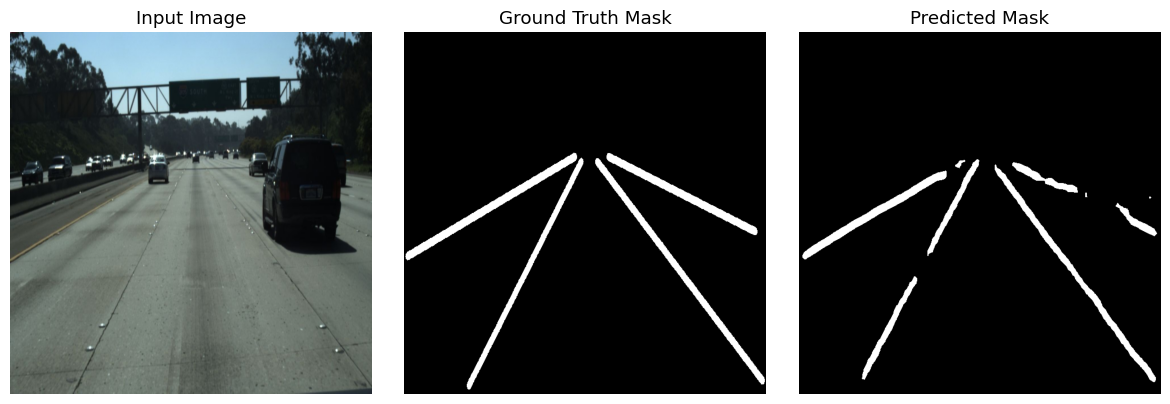

In [60]:
show_sample_prediction(model, lane_test_dataset, device, index=0)


In [68]:
def show_sample_prediction_overlay(model, dataset, device, index=0, alpha=0.4, color=(1, 0, 0)):
    model.eval()
    
    # Get sample from dataset
    image, _, true_mask = dataset[index]
    image_tensor = image.unsqueeze(0).to(device)  # (1, 3, H, W)

    with torch.no_grad():
        _, pred_mask = model(image_tensor)
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask = (pred_mask > 0.5).float()

    # Convert image to NumPy
    img_np = image.permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
    pred_np = pred_mask.squeeze().cpu().numpy()    # (H', W')

    # 🔧 Print image resolution
    print(f"Image resolution: {img_np.shape[1]} x {img_np.shape[0]} (Width x Height)")

    # 🔧 Resize pred mask to match original image size
    pred_np = cv2.resize(pred_np, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Normalize image to [0, 1] range
    if img_np.max() > 1.0:
        img_np = img_np / 255.0

    # Create color overlay
    overlay = np.zeros_like(img_np)
    overlay[:, :, 0] = color[0]  # R
    overlay[:, :, 1] = color[1]  # G
    overlay[:, :, 2] = color[2]  # B

    # Apply overlay to predicted mask regions
    blended = img_np.copy()
    blended[pred_np == 1] = (1 - alpha) * blended[pred_np == 1] + alpha * overlay[pred_np == 1]

    # Plot side-by-side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(blended)
    plt.title("Overlay: Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


Image resolution: 640 x 640 (Width x Height)


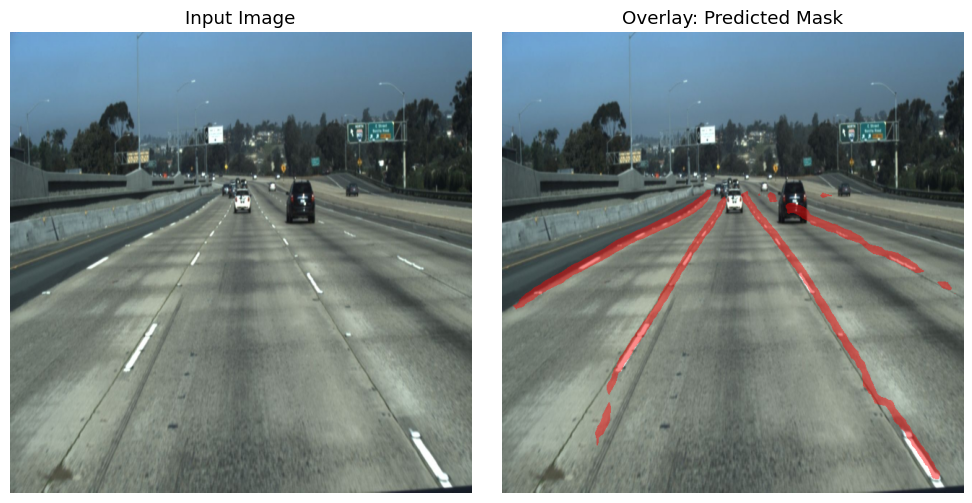

In [69]:
# --- 4) Use the function on a specific sample ---
# Visualize a specific index
idx = 150  # change index to any valid item
show_sample_prediction_overlay(model, lane_test_dataset, device, index=idx, alpha=0.45, color=(1, 0, 0))

In [ ]:
# ----------------------------
# Visualization / sanity helpers
# ----------------------------

@torch.inference_mode()
def show_vehicle_on_df_index_v2(
    df, idx, dataset_root, model: YoloV5WithSeg, size=640,
    conf_thresh=0.25, only_vehicle=True, save=False, out_dir="./yolo_vis"
):
    img_rel = str(df.iloc[idx]["raw_file"])
    img_path = str(Path(dataset_root) / img_rel)

    device = next(model.parameters()).device
    model.eval()
    det_xyxy, _ = model.detect(img_path, size=size, device=device, return_logits=False)

    dets = det_xyxy.detach().cpu().numpy() if det_xyxy is not None else np.zeros((0, 6), dtype=np.float32)
    names = model.names or []
    vehicle_ids = {i for i, n in enumerate(names) if n in VEHICLE_SET}

    im = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(im)
    try:
        font = ImageFont.truetype("arial.ttf", 14)
    except Exception:
        font = ImageFont.load_default()

    for x1, y1, x2, y2, conf, cls_id in dets:
        conf = float(conf); cls_id = int(cls_id)
        if conf < conf_thresh:
            continue
        if only_vehicle and cls_id not in vehicle_ids:
            continue

        name = names[cls_id] if 0 <= cls_id < len(names) else str(cls_id)
        label = f"{name} {conf:.2f}"

        draw.rectangle([(x1, y1), (x2, y2)], outline=(0, 255, 0), width=3)
        # text background + text
        # PIL textlength is newer; guard for compatibility
        try:
            tw = draw.textlength(label, font=font)
            th = font.getbbox(label)[3]
        except Exception:
            tw, th = font.getsize(label)
        x_txt, y_txt = int(x1), max(0, int(y1) - int(th) - 4)
        draw.rectangle([(x_txt, y_txt), (x_txt + int(tw) + 6, y_txt + int(th) + 4)], fill=(0, 255, 0))
        draw.text((x_txt + 3, y_txt + 2), label, fill=(0, 0, 0), font=font)

    plt.figure(figsize=(12, 7))
    plt.imshow(im)
    plt.axis("off")
    plt.show()

    if save:
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        out_file = Path(out_dir) / f"{Path(img_path).stem}_veh.png"
        im.save(out_file)
        print("Saved:", out_file)


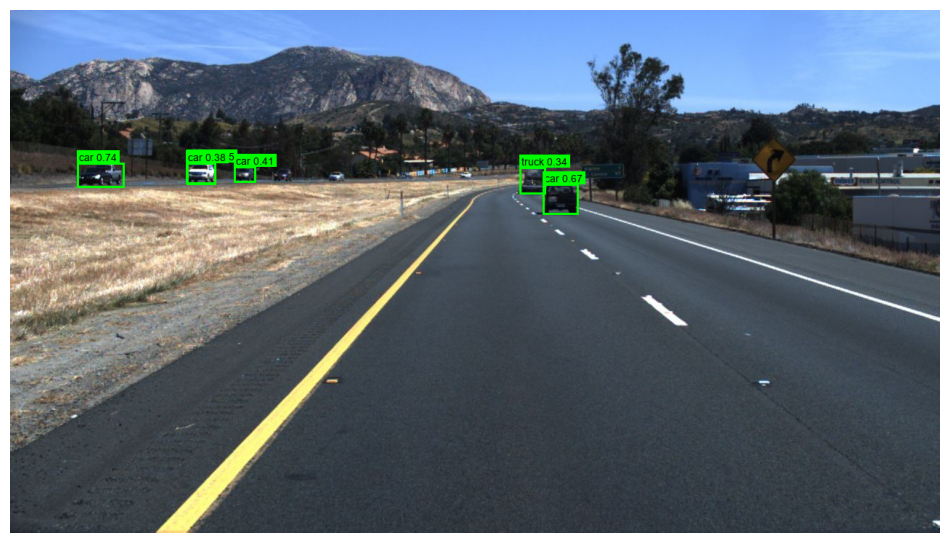

In [86]:
#Test
df_json_test = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\test_set\test_tasks_0627.json", lines = True)

# model = your trained YoloV5WithSeg (already loaded & on device)
DATASET_ROOT = r"Z:\EE_297A\dataset\lanes\TUSimple\test_set"  # folder that contains 'clips'
model.eval()
model.yolo.eval()
show_vehicle_on_df_index_v2(df_json_test, idx=100, dataset_root=DATASET_ROOT, model=model,
                            size=640, conf_thresh=0.00, only_vehicle=True, save=False)

### BOTH OVERLAY

In [56]:
import numpy as np
import torch
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import cv2

VEHICLE_SET = {'car','bus','truck','motorcycle','bicycle'}

@torch.inference_mode()
def show_det_and_seg_overlay(
    df, idx, dataset_root, model,
    size=640,
    conf_thresh=0.25,
    only_vehicle=True,
    seg_thresh=0.5,
    seg_color=(255, 0, 0),   # red overlay (RGB)
    alpha=0.35,              # segmentation overlay opacity
    save=False,
    out_dir="./yolo_vis"
):
    """
    Draws the segmentation overlay AND detection boxes on the same image.
    - df[idx]["raw_file"] must point to the relative path of the image
    - model must be an instance of YoloV5WithSeg (shared encoder)
    """
    # 1) Resolve image path
    img_rel = str(df.iloc[idx]["raw_file"])
    img_path = str(Path(dataset_root) / img_rel)

    # 2) Run model.detect() => boxes + seg prob (already resized to input's original size in your impl)
    device = next(model.parameters()).device
    model.eval()
    det_xyxy, seg_prob = model.detect(img_path, size=size, device=device, return_logits=False)

    # 3) Load original image as numpy (H, W, 3) in [0,255]
    im = Image.open(img_path).convert("RGB")
    img_np = np.array(im).astype(np.float32)

    # 4) Make a colored segmentation overlay from seg_prob
    if isinstance(seg_prob, torch.Tensor):
        seg_np = seg_prob.detach().cpu().numpy()
    else:
        seg_np = np.array(seg_prob)

    # If seg_np not same size, resize (safety)
    if seg_np.shape[:2] != img_np.shape[:2]:
        seg_np = cv2.resize(seg_np, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_LINEAR)

    seg_bin = (seg_np >= seg_thresh).astype(np.float32)  # 0/1 mask

    # Blend colored overlay on top of the image where mask==1
    overlay = np.zeros_like(img_np, dtype=np.float32)
    overlay[..., 0] = seg_color[0]
    overlay[..., 1] = seg_color[1]
    overlay[..., 2] = seg_color[2]

    blended = img_np.copy()
    mask = seg_bin[..., None]  # (H,W,1)
    blended = (1 - alpha * mask) * blended + (alpha * mask) * overlay

    # 5) Draw detections on the blended image (PIL draw)
    dets = det_xyxy.detach().cpu().numpy() if det_xyxy is not None else np.zeros((0, 6), dtype=np.float32)
    names = getattr(model, "names", None) or getattr(model.yolo, "names", []) or []
    vehicle_ids = {i for i, n in enumerate(names) if n in VEHICLE_SET}

    vis_im = Image.fromarray(np.clip(blended, 0, 255).astype(np.uint8))
    draw = ImageDraw.Draw(vis_im)
    try:
        font = ImageFont.truetype("arial.ttf", 14)
    except Exception:
        font = ImageFont.load_default()

    for x1, y1, x2, y2, conf, cls_id in dets:
        conf = float(conf); cls_id = int(cls_id)
        if conf < conf_thresh:
            continue
        if only_vehicle and cls_id not in vehicle_ids:
            continue

        # Box + label
        name = names[cls_id] if 0 <= cls_id < len(names) else str(cls_id)
        label = f"{name} {conf:.2f}"

        draw.rectangle([(x1, y1), (x2, y2)], outline=(0, 255, 0), width=3)
        # Text box
        try:
            tw = draw.textlength(label, font=font)
            th = font.getbbox(label)[3]
        except Exception:
            tw, th = font.getsize(label)
        x_txt, y_txt = int(x1), max(0, int(y1) - int(th) - 4)
        draw.rectangle([(x_txt, y_txt), (x_txt + int(tw) + 6, y_txt + int(th) + 4)], fill=(0, 255, 0))
        draw.text((x_txt + 3, y_txt + 2), label, fill=(0, 0, 0), font=font)

    # 6) Show
    plt.figure(figsize=(12, 7))
    plt.imshow(vis_im)
    plt.axis("off")
    plt.title("Detections + Lane Segmentation")
    plt.show()

    # 7) Optional save
    if save:
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        out_file = Path(out_dir) / f"{Path(img_path).stem}_det_seg_overlay.png"
        vis_im.save(out_file)
        print("Saved:", out_file)


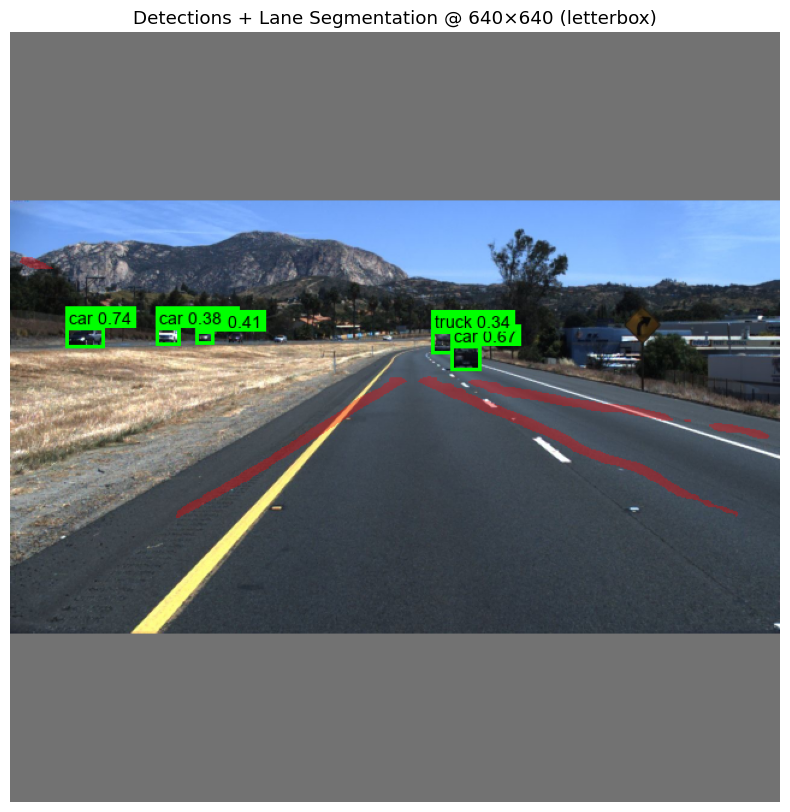

In [88]:
# Assuming:
# - model is your trained YoloV5WithSeg on the correct device
# - df_json is your dataframe with a "raw_file" column
# - DATASET_ROOT points to the dataset root dir that contains those relative paths

model.eval()
show_det_and_seg_overlay(
    df=df_json_test,
    idx=100,
    dataset_root=DATASET_ROOT,
    model=model,
    size=640,
    conf_thresh=0.25,
    only_vehicle=True,
    seg_thresh=0.5,
    seg_color=(255, 0, 0),   # red lanes
    alpha=0.35,
    save=False
)


In [89]:
### Resize Issue: 

In [90]:
import numpy as np, torch, cv2
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

VEHICLE_SET = {'car','bus','truck','motorcycle','bicycle'}

def _letterbox_canvas(im_rgb, new_shape=640, color=(114,114,114)):
    """Return (canvas_rgb_640, r, dw, dh) matching YOLO letterbox geometry."""
    h, w = im_rgb.shape[:2]
    if isinstance(new_shape, int): new_shape = (new_shape, new_shape)
    r = min(new_shape[0]/h, new_shape[1]/w)
    new_unpad = (int(round(w*r)), int(round(h*r)))
    dw = (new_shape[1] - new_unpad[0]) / 2
    dh = (new_shape[0] - new_unpad[1]) / 2
    resized = cv2.resize(im_rgb, new_unpad, interpolation=cv2.INTER_LINEAR)
    canvas = np.full((new_shape[0], new_shape[1], 3), color, dtype=np.uint8)
    top, left = int(round(dh - 0.1)), int(round(dw - 0.1))
    canvas[top:top+resized.shape[0], left:left+resized.shape[1]] = resized
    return canvas, r, dw, dh

@torch.inference_mode()
def show_det_and_seg_overlay_same_res(
    df, idx, dataset_root, model,
    target_size=640,
    conf_thresh=0.25,
    only_vehicle=True,
    seg_thresh=0.5,
    seg_color=(255, 0, 0),
    alpha=0.35,
    save=False,
    out_dir="./yolo_vis",
    morph_close_ks=5  # 0 to disable
):
    # -------- 1) get file + run detection (returns ORIGINAL-size outputs) --------
    img_rel = str(df.iloc[idx]["raw_file"])
    img_path = str(Path(dataset_root) / img_rel)

    device = next(model.parameters()).device
    model.eval()
    det_xyxy, seg_prob = model.detect(img_path, size=target_size, device=device, return_logits=False)

    # load original RGB
    im0_bgr = cv2.imread(img_path); 
    if im0_bgr is None: raise FileNotFoundError(img_path)
    im0 = cv2.cvtColor(im0_bgr, cv2.COLOR_BGR2RGB)
    H0, W0 = im0.shape[:2]

    # -------- 2) build a true YOLO letterboxed 640×640 canvas (no distortion) --------
    canvas, r, dw, dh = _letterbox_canvas(im0, new_shape=target_size)

    # -------- 3) project seg prob (orig -> letterbox canvas) --------
    seg_np = seg_prob.detach().cpu().numpy() if isinstance(seg_prob, torch.Tensor) else np.array(seg_prob)
    seg_resized = cv2.resize(seg_np, (int(round(W0*r)), int(round(H0*r))), interpolation=cv2.INTER_LINEAR)
    canvas_seg = np.zeros((target_size, target_size), dtype=np.float32)
    top, left = int(round(dh - 0.1)), int(round(dw - 0.1))
    canvas_seg[top:top+seg_resized.shape[0], left:left+seg_resized.shape[1]] = seg_resized

    # optional clean-up to connect gaps
    if morph_close_ks and morph_close_ks > 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_close_ks, morph_close_ks))
        canvas_seg = cv2.morphologyEx(canvas_seg, cv2.MORPH_CLOSE, k)

    seg_bin = (canvas_seg >= seg_thresh).astype(np.float32)

    # -------- 4) project boxes (orig -> letterbox canvas) --------
    dets = det_xyxy.detach().cpu().numpy() if det_xyxy is not None else np.zeros((0, 6), dtype=np.float32)
    if dets.size:
        dets_640 = dets.copy()
        dets_640[:, [0,2]] = dets_640[:, [0,2]] * r + dw  # x1,x2
        dets_640[:, [1,3]] = dets_640[:, [1,3]] * r + dh  # y1,y2
    else:
        dets_640 = dets

    # -------- 5) blend seg on the letterboxed canvas --------
    overlay = np.zeros_like(canvas, dtype=np.float32)
    overlay[..., 0] = seg_color[0]; overlay[..., 1] = seg_color[1]; overlay[..., 2] = seg_color[2]
    mask = seg_bin[..., None]
    blended = (1 - alpha*mask) * canvas.astype(np.float32) + (alpha*mask) * overlay
    blended = np.clip(blended, 0, 255).astype(np.uint8)

    # -------- 6) draw boxes --------
    names = getattr(model, "names", None) or getattr(model.yolo, "names", []) or []
    vehicle_ids = {i for i, n in enumerate(names) if n in VEHICLE_SET}

    vis_im = Image.fromarray(blended)
    draw = ImageDraw.Draw(vis_im)
    try:
        font = ImageFont.truetype("arial.ttf", 14)
    except Exception:
        font = ImageFont.load_default()

    for x1, y1, x2, y2, conf, cls_id in dets_640:
        conf = float(conf); cls_id = int(cls_id)
        if conf < conf_thresh: continue
        if only_vehicle and cls_id not in vehicle_ids: continue

        name = names[cls_id] if 0 <= cls_id < len(names) else str(cls_id)
        label = f"{name} {conf:.2f}"
        draw.rectangle([(x1, y1), (x2, y2)], outline=(0,255,0), width=3)
        try:
            tw = draw.textlength(label, font=font); th = font.getbbox(label)[3]
        except Exception:
            tw, th = font.getsize(label)
        x_txt, y_txt = int(x1), max(0, int(y1) - int(th) - 4)
        draw.rectangle([(x_txt, y_txt), (x_txt + int(tw) + 6, y_txt + int(th) + 4)], fill=(0,255,0))
        draw.text((x_txt + 3, y_txt + 2), label, fill=(0,0,0), font=font)

    # -------- 7) show / save --------
    plt.figure(figsize=(10,10))
    plt.imshow(vis_im); plt.axis("off")
    plt.title(f"Detections + Lane Segmentation @ {target_size}×{target_size} (letterbox)")
    plt.show()

    if save:
        out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
        out_file = out_dir / f"{Path(img_path).stem}_det_seg_lb_{target_size}.png"
        vis_im.save(out_file)
        print("Saved:", out_file)


In [91]:
def show_det_and_seg_overlay(
    df, idx, dataset_root, model,
    size=640, conf_thresh=0.25, only_vehicle=True,
    seg_thresh=0.5, seg_color=(255,0,0), alpha=0.35, save=False, out_dir="./yolo_vis"
):
    return show_det_and_seg_overlay_same_res(
        df, idx, dataset_root, model,
        target_size=size, conf_thresh=conf_thresh, only_vehicle=only_vehicle,
        seg_thresh=seg_thresh, seg_color=seg_color, alpha=alpha, save=save, out_dir=out_dir
    )


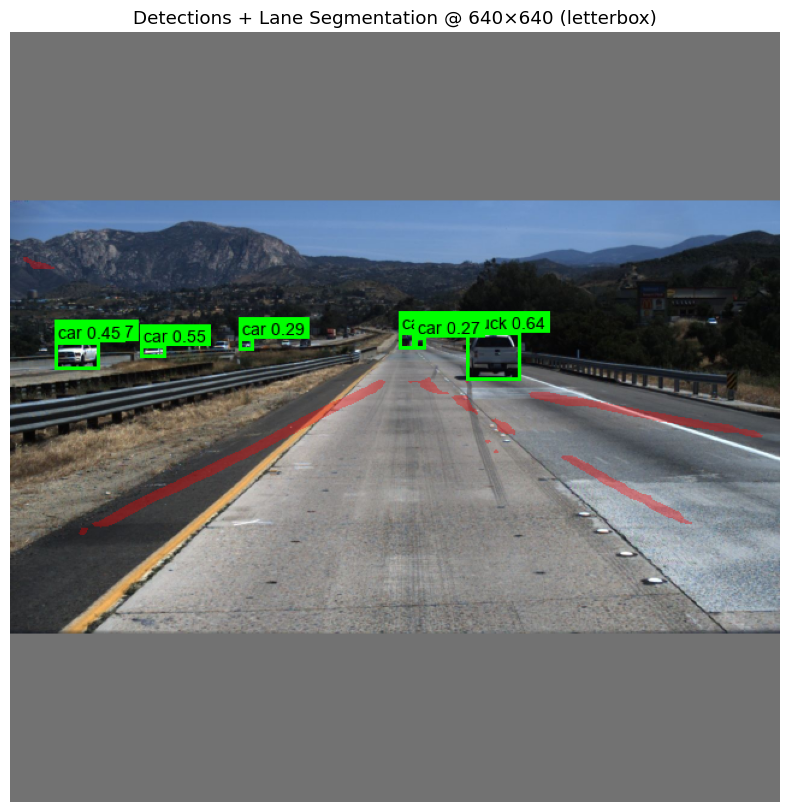

In [95]:
# 1) Model on device (skip the load part if you already have `model`)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()

# 3) Show a single overlay (no save)
show_det_and_seg_overlay_same_res(
    df=df_json_test,
    idx=150,
    dataset_root=DATASET_ROOT,
    model=model,
    target_size=640,          # match your seg training size
    conf_thresh=0.25,
    only_vehicle=True,
    seg_thresh=0.5,
    seg_color=(255, 0, 0),
    alpha=0.35,
    save=False
)